In [63]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random

In [64]:
# load data
ego_updates = pd.read_csv('../Clean/ego_updates.csv')
updates = pd.read_csv('../Clean/updates.csv')


# Preliminary Analysis

compute the distance to each of the simulated paths that corespond to the pair of theta and omega for each subject. Plot the simulation at 0 and the average deviation from the simulation for across all types.

take the simulation with the minimal distance for each data path and assign the subject to that model

Coumpute the share of paths that are assigned to each model.

Check if the assignment is different in the two treatments

Check if the distances are different in the two treatments

### The Shares of Subjects that are Overconfident, Underconfident and Correctly Specified

Text(0, 0.5, 'Share')

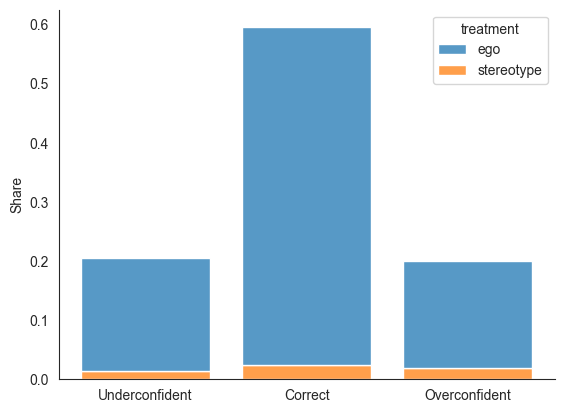

In [65]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates, 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')

Text(0.5, 1.0, 'Misspecifications')

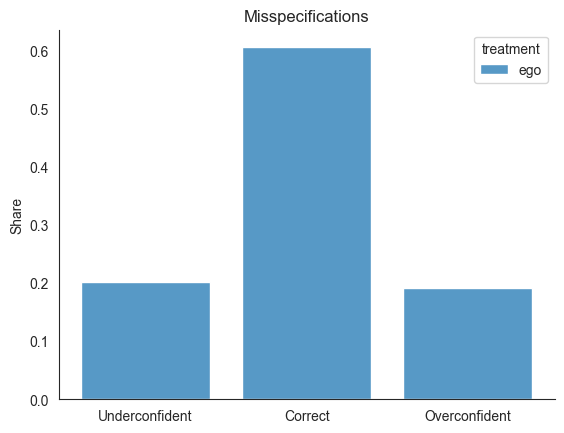

In [66]:
# from the table updates plot the shares of subjects in each of the misspecification categories
sns.set_style("white")

ax = sns.histplot(x="misspecification_num", hue="treatment", data=updates[updates['treatment']=='ego'], 
                  multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('')
plt.xticks([-1,0,1], ['Underconfident', 'Correct', 'Overconfident'])
plt.ylabel('Share')
plt.title('Misspecifications')

## Add a column that indicates if their type-belief changed from the previous round

In [67]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)

 
# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})




In [68]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')





Text(0.5, 1.0, 'Belief changes by treatment')

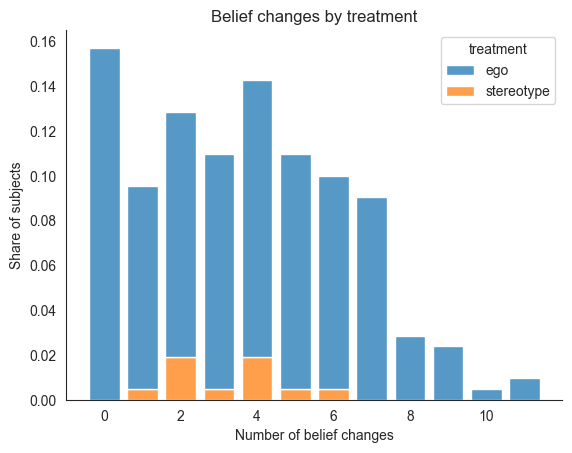

In [69]:
# if the indicator is more than 0 then the belief changed at least once and these subjects cannot possibly be dogmatic.
# plot the share of subjects for whom the belief never changed and the share for whom it did
sns.set_style("white")
sns.histplot(data=updates, x='change_indicator_sum', hue='treatment', multiple='stack', stat='probability', shrink=.8, discrete=True)
sns.despine()
plt.xlabel('Number of belief changes')
plt.ylabel('Share of subjects')
plt.title('Belief changes by treatment')

## Likelihoods

In [70]:
## Likelihoods
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in range(11):
        
        e_t = int(player.loc[player['round_number']==t+1, 'effort'])
        theta = int(player.loc[player['round_number']==t+1, 'theta'])
        belief = int(player.loc[player['round_number']==t+1, 'belief'])
        omega = int(player.loc[player['round_number']==t+1, 'omega'])
        s_t = int(player.loc[player['round_number']==t+1, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_true = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0))))
        posterior_belief = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0))))

        p_true = sp.stats.binom.pmf(s_t, 10, msc[theta][e_t, :], loc=0)@posterior_true
        p_belief = sp.stats.binom.pmf(s_t, 10, msc[belief][e_t, :], loc=0)@posterior_belief
        # multiply all the elements in p_true and p_belief
        l_true = np.prod(p_true)
        l_belief = np.prod(p_belief)
        # calculate the likelihood ratio
        lr_t.append(l_true/l_belief)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[updates['player_code']==c, 'lr'] = lr_t

## Compute alpha


In [71]:
# calculate the average of lr for the rows in which change_indicator is 1
alpha = updates.loc[(updates['change_indicator']==1) & (updates['lr']<5), 'lr'].mean()
alpha

1.1042435545957145

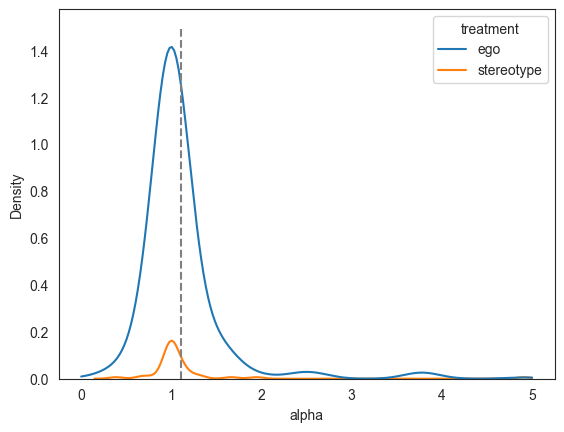

In [72]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1)], x = 'lr', 
            hue='treatment', clip=(0, 5), bw_adjust=.1)
plt.xlabel('alpha')
plt.vlines([alpha], 0, 1.5, color = 'gray', linestyles='--')

Text(0.5, 1.0, 'Switching Threshold by treatment')

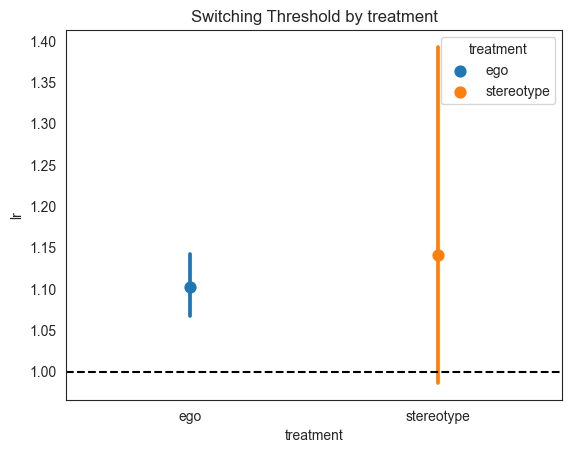

In [73]:
# plot the estimates of alpha by treatment
sns.pointplot(data=updates[(updates['change_indicator']==1) & (updates['lr']<5)], y='lr', x='treatment', join =False, hue='treatment')
plt.axhline(y=1, color='black', linestyle='--')
plt.title('Switching Threshold by treatment')

** Should it be gender/topic specific? test if they are different*
This requires adding the gender data to the updates table

In [74]:
# use alpha to simulate the switcher's path. 

## Add the simulation data and reshape to merge to the experiment's data

In [75]:
# import the simulation data
sim = pd.read_csv("../Simulations/demo/data/simulation.csv")

In [76]:
updates['topic'].unique()

array(['Science and Technology', 'Math', 'Verbal', 'Pop-Culture and Art',
       'Sports and Video Games', 'US Geography'], dtype=object)

In [77]:
# split the data by initial belief and add the relevant simulations given the initial belief and the true omega and theta
initial_L = updates.loc[updates['belief']==0]
initial_M = updates.loc[updates['belief']==1]
initial_H = updates.loc[updates['belief']==2]




In [78]:
# adjust the round numbers from the simulation to match the data (get rif od rounf 0 of the simulation, it was just the starting parameters)
sim['round_number_modif'] = sim['round_number']+1
sim['round_number_modif'] = sim['round_number_modif'].astype(int)

# split the simulations by initial beliefs
sim_L = sim[['e_lr_L', 'e_dog_L', 'e_bay', 'e_ss', 'theta_lr_L', 'theta', 'omega', 'round_number_modif']]
sim_M = sim[['e_lr_M', 'e_dog_M', 'e_bay', 'e_ss', 'theta_lr_M', 'theta', 'omega', 'round_number_modif']]
sim_H = sim[['e_lr_H', 'e_dog_H', 'e_bay', 'e_ss', 'theta_lr_H', 'theta', 'omega', 'round_number_modif']]



In [79]:
sim_L = sim_L.rename(columns={'e_lr_L':'switcher', 
                      'e_dog_L':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'theta_lr_L':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_M = sim_M.rename(columns={'e_lr_M':'switcher', 
                      'e_dog_M':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'theta_lr_M':'switcher_belief',
                      'round_number_modif':'round_number'})

sim_H = sim_H.rename(columns={'e_lr_H':'switcher', 
                      'e_dog_H':'dogmatic', 
                      'e_ss':'self-serving', 
                      'e_bay':'bayesian', 
                      'theta_lr_H':'switcher_belief',
                      'round_number_modif':'round_number'})

In [80]:
sim_L['belief'] = 0
sim_M['belief'] = 1
sim_H['belief'] = 2

In [81]:
sim = pd.concat([sim_L, sim_M, sim_H])

In [82]:
# merge with the update data on the round number, the belief and the theta and omega. 
updates = updates.merge(sim, on=['round_number', 'belief', 'theta', 'omega'], how='left')

## Distances to the simulated paths

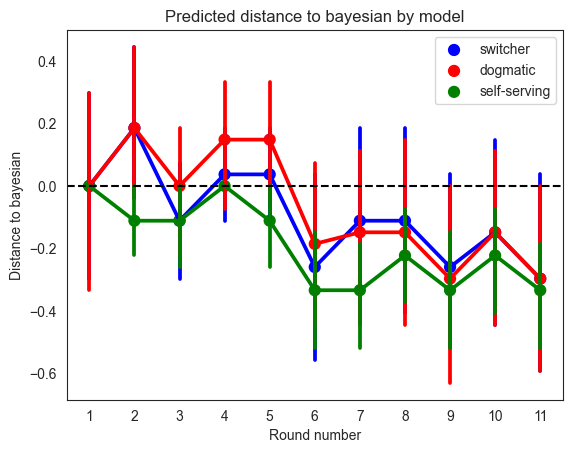

In [83]:
# compare the simulations to the bayesian simulation by taking the distance from each of the simulations to the bayesian simulation
# and then plot all of them
# first take the distance from switcher to bayesian
sim['switcher_bayesian'] = sim['switcher'] - sim['bayesian']
# then take the distance from dogmatic to bayesian
sim['dogmatic_bayesian'] = sim['dogmatic'] - sim['bayesian']
# then take the distance from self-serving to bayesian
sim['self-serving_bayesian'] = sim['self-serving'] - sim['bayesian']

# plot each of the distances as a line in the same plot
sns.set_style("white")
sns.pointplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
sns.pointplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
sns.pointplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Distance to bayesian')
plt.xlabel('Round number')
plt.title('Predicted distance to bayesian by model')
plt.legend()

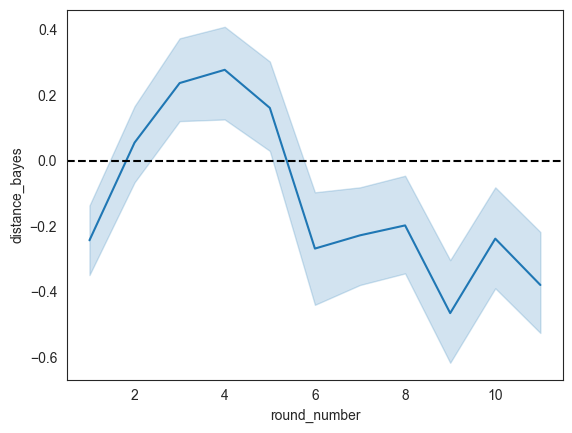

In [84]:
# compute the distance between the observed effort choices and what a bayesian agent would have done
updates['distance_bayes'] = updates['effort']- updates['bayesian']

# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_bayes')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 

plt.savefig('distance_bayes.png', dpi=300)


## Do the plots for each case of misspecification separately. 


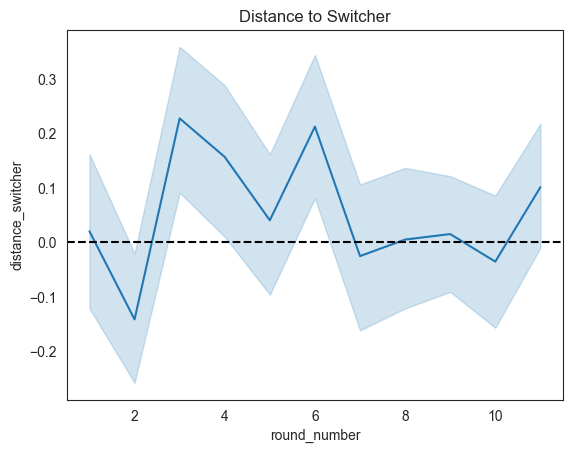

In [85]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher'] = updates['effort'] - updates['switcher']
updates['distance_dogmatic'] = updates['effort'] - updates['dogmatic']
updates['distance_bayesian'] = updates['effort'] - updates['bayesian']
updates['distance_self-serving'] = updates['effort'] - updates['self-serving']

# plot the distance over rounds for each of the MODES

# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_switcher')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher')
plt.savefig('../figures/distance_switcher.png')

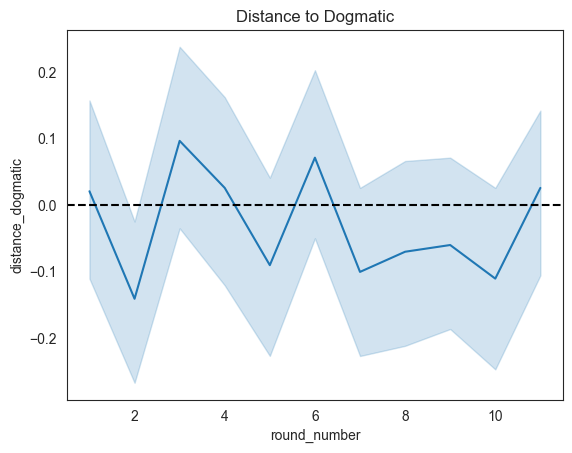

In [86]:
# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=updates[updates['treatment']=='ego'], x='round_number', y='distance_dogmatic')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic')

plt.savefig('../figures/distance_dogmatic.png')

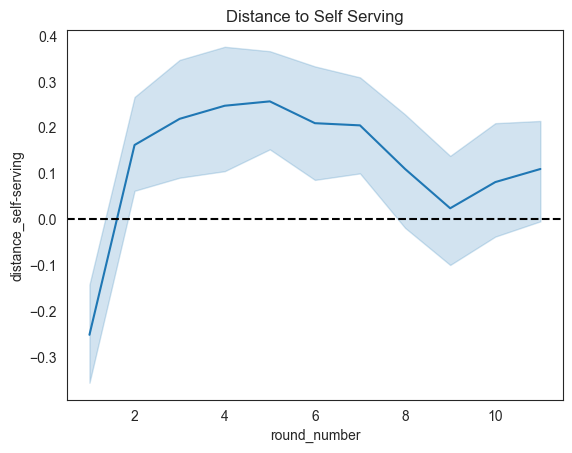

In [87]:
# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving')

plt.savefig('../figures/distance_self-serving.png')

In [88]:
# create a function that takes in theta and omega and the data and returns 8 plots
def plot(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0])
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1])
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2])
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0])
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1])
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [89]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot(updates, t, o)
        plt.savefig('../figures/updates_'+str(t)+str(o)+'.png')
        plt.close()

In [90]:
# create a function that takes in theta and omega and the data and returns 8 plots and plots each treatment separately
def plot_treatment(data, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))

    table = data.loc[(data['theta']==theta) & (data['omega']==omega), :]

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[0,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='switcher', ax=axs[0,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[0,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='switcher', ax=axs[0,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[0,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='switcher', ax=axs[0,2], color='black')

    sns.lineplot(data=table[table['belief']==0], x='round_number', y='effort', ax=axs[1,0], hue='treatment')
    sns.lineplot(data=table[table['belief']==0], x='round_number', y='dogmatic', ax=axs[1,0], color='black')

    sns.lineplot(data=table[table['belief']==1], x='round_number', y='effort', ax=axs[1,1], hue='treatment')
    sns.lineplot(data=table[table['belief']==1], x='round_number', y='dogmatic', ax=axs[1,1], color='black')

    sns.lineplot(data=table[table['belief']==2], x='round_number', y='effort', ax=axs[1,2], hue='treatment')
    sns.lineplot(data=table[table['belief']==2], x='round_number', y='dogmatic', ax=axs[1,2], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,0], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='bayesian', ax=axs[2,0], color='black')

    sns.lineplot(data=table, x='round_number', y='effort', ax=axs[2,1], hue='treatment')
    sns.lineplot(data=table, x='round_number', y='self-serving', ax=axs[2,1], color='black')
    
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

   
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

In [91]:
# make all the plots and save them in the figures folder
for t in [0,1,2]:
    for o in [0,1,2]:
        plot_treatment(updates, t, o)
        plt.savefig('../figures/updates_by_treatment'+str(t)+str(o)+'.png')
        plt.close()

# Try to Classify subjects based on their behavior

In [92]:
updates.columns

Index(['index', 'code', 'round_number', 'effort', 'fails', 'last_button',
       'score', 'topic', 'signal', 'belief', 'certainty', 'theta', 'omega',
       'treatment', 'overconfident', 'underconfident', 'correct',
       'misspecification', 'misspecification_num', 'topic_num', 'player_code',
       'current_belief_start', 'belief_change', 'change_indicator',
       'change_indicator_sum', 'lr', 'log_lr', 'switcher', 'dogmatic',
       'bayesian', 'self-serving', 'switcher_belief', 'distance_bayes',
       'distance_switcher', 'distance_dogmatic', 'distance_bayesian',
       'distance_self-serving'],
      dtype='object')

In [93]:
# compute the difference between effort and each of the simulated models
updates['distance_switcher_abs'] = np.abs(updates['effort'] - updates['switcher'])
updates['distance_dogmatic_abs'] = np.abs(updates['effort'] - updates['dogmatic'])
updates['distance_bayesian_abs'] = np.abs(updates['effort'] - updates['bayesian'])
updates['distance_self-serving_abs'] = np.abs(updates['effort'] - updates['self-serving'])

# create a new data set with the sum the computed distences by player_code for each of the models
distances = pd.DataFrame()
distances['distance_switcher_sum'] = updates.groupby('player_code')['distance_switcher_abs'].sum()
distances['distance_dogmatic_sum'] = updates.groupby('player_code')['distance_dogmatic_abs'].sum()
distances['distance_bayesian_sum'] = updates.groupby('player_code')['distance_bayesian_abs'].sum()
distances['distance_self-serving_sum'] = updates.groupby('player_code')['distance_self-serving_abs'].sum()

# for each player_code, return the model that has the smallest sum
distances['best_model'] = np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)

# merge with the updates data 
updates.merge(distances, on='player_code', how='left')

,index,code,round_number,effort,fails,last_button,score,topic,signal,belief,...,distance_self-serving,distance_switcher_abs,distance_dogmatic_abs,distance_bayesian_abs,distance_self-serving_abs,distance_switcher_sum,distance_dogmatic_sum,distance_bayesian_sum,distance_self-serving_sum,best_model
0,0,0m2xzxgv,1,1,9,2,9.0,Science and Technology,1,0,...,0,1,1,0,0,10,9,10,10,1
1,1,0m2xzxgv,2,1,7,1,9.0,Science and Technology,3,0,...,1,0,0,1,1,10,9,10,10,1
2,2,0m2xzxgv,3,2,10,2,9.0,Science and Technology,0,0,...,2,2,1,2,2,10,9,10,10,1
3,3,0m2xzxgv,4,0,7,0,9.0,Science and Technology,3,0,...,0,0,1,0,0,10,9,10,10,1
4,4,0m2xzxgv,5,0,8,1,9.0,Science and Technology,2,0,...,0,0,1,0,0,10,9,10,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,2305,magz1oz9,7,1,5,1,11.0,US Geography,5,1,...,0,0,0,1,0,0,0,6,0,0
2306,2306,magz1oz9,8,1,4,1,11.0,US Geography,6,1,...,0,0,0,1,0,0,0,6,0,0
2307,2307,magz1oz9,9,1,5,1,11.0,US Geography,5,1,...,0,0,0,1,0,0,0,6,0,0
2308,2308,magz1oz9,10,1,3,1,11.0,US Geography,7,1,...,0,0,0,1,0,0,0,6,0,0


In [94]:
np.argmin(distances[['distance_switcher_sum', 'distance_dogmatic_sum', 'distance_bayesian_sum', 'distance_self-serving_sum']].values, axis=1)


array([0, 1, 0, 0, 2, 3, 0, 2, 0, 3, 0, 0, 0, 2, 0, 3, 2, 3, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 3, 1, 0, 3, 2, 3, 2, 2, 1, 0, 0, 3, 3, 0, 0, 1, 2, 0, 3, 0, 0,
       0, 0, 0, 2, 2, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 2,
       2, 0, 1, 1, 0, 0, 3, 0, 0, 0, 2, 0, 2, 0, 0, 3, 3, 2, 0, 0, 2, 0,
       3, 0, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       2, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 2, 0, 0, 3, 0, 3, 3, 2, 0, 0, 0,
       0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 3, 0, 3, 3, 0, 3])

# Is treatment different from control?
Do they abandon misspecified beliefs faster in the steroetype treatment?
Are misspecifications more or less common

Is the classification different in the two treatments?

Is alpha different in treatment than in control?

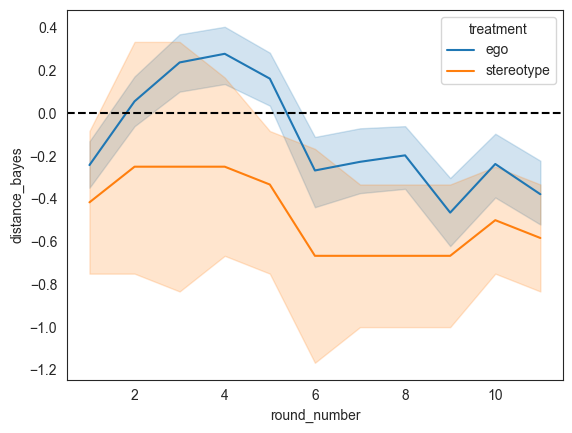

In [95]:
# plot the distance over rounds for each of the treatments
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_bayes', hue='treatment')
#sns.lineplot(data=sim, x='round_number', y='switcher_bayesian', label='switcher', color='blue')
#sns.lineplot(data=sim, x='round_number', y='dogmatic_bayesian', label='dogmatic', color='red')
#sns.lineplot(data=sim, x='round_number', y='self-serving_bayesian', label='self-serving', color='green')
# add a horizontal line at 0 to indicate the bayesian choice
plt.axhline(y=0, color='black', linestyle='--') 

plt.savefig('../figures/distance_bayes_treatment.png')

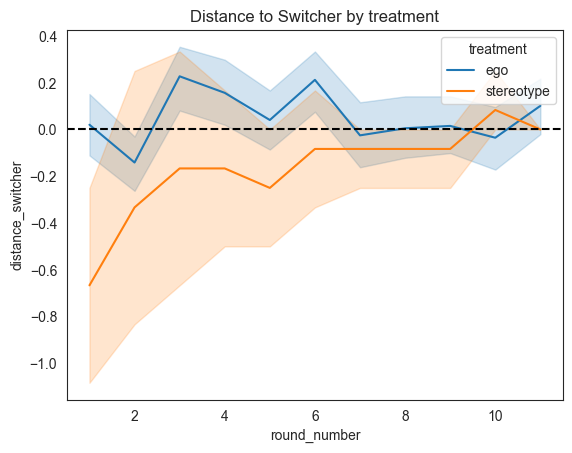

In [96]:
# plot the distance over rounds for each of the treatments and each of the models
# first plot the distance to the switcher
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_switcher', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Switcher by treatment')
plt.savefig('../figures/distance_switcher_treatment.png')

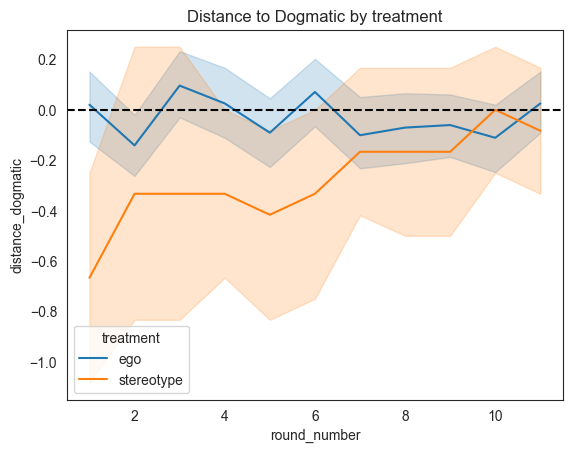

In [97]:



# plot the distance to the dogmatic
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_dogmatic', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Dogmatic by treatment')

plt.savefig('../figures/distance_dogmatic_treatment.png')

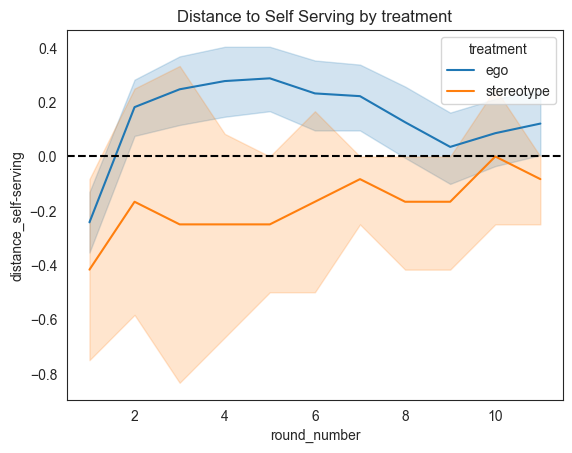

In [98]:

# plot the distance to the self-serving
sns.set_style("white")
sns.lineplot(data=updates, x='round_number', y='distance_self-serving', hue='treatment')
# add a horizontal line at 0 to indicate the models choice
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distance to Self Serving by treatment')

plt.savefig('../figures/distance_self-serving_treatment.png')

### T-tests
test if the difference between the observed data and the simulations are different from cero and order them from best fit to worst fit.
plot points with confidence intervals

# What are the characterising features of the subjects that are misspecified?
Do are misspecified subjects more likely to attribute it to others?

## Try to estimate parameters for Self-Attribution bias

In [99]:
updates['certainty']= updates['certainty']/100

In [100]:
updates['certainty']

0       0.75
1       0.75
2       0.75
3       0.75
4       0.75
        ... 
2305    0.75
2306    0.75
2307    0.75
2308    0.75
2309    0.75
Name: certainty, Length: 2310, dtype: float64

### scores

<Axes: xlabel='score', ylabel='Density'>

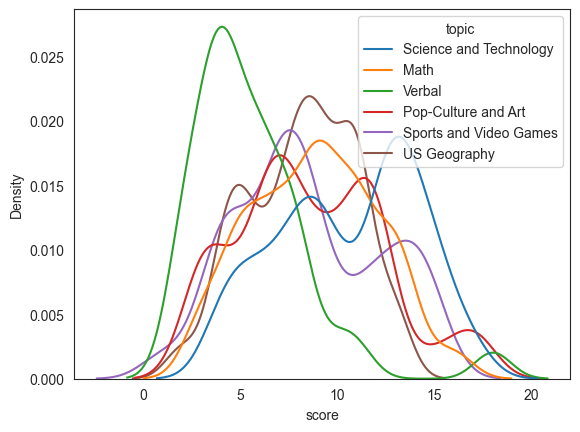

In [101]:
sns.kdeplot(data=updates, x='score', hue='topic')

<Axes: xlabel='belief', ylabel='Density'>

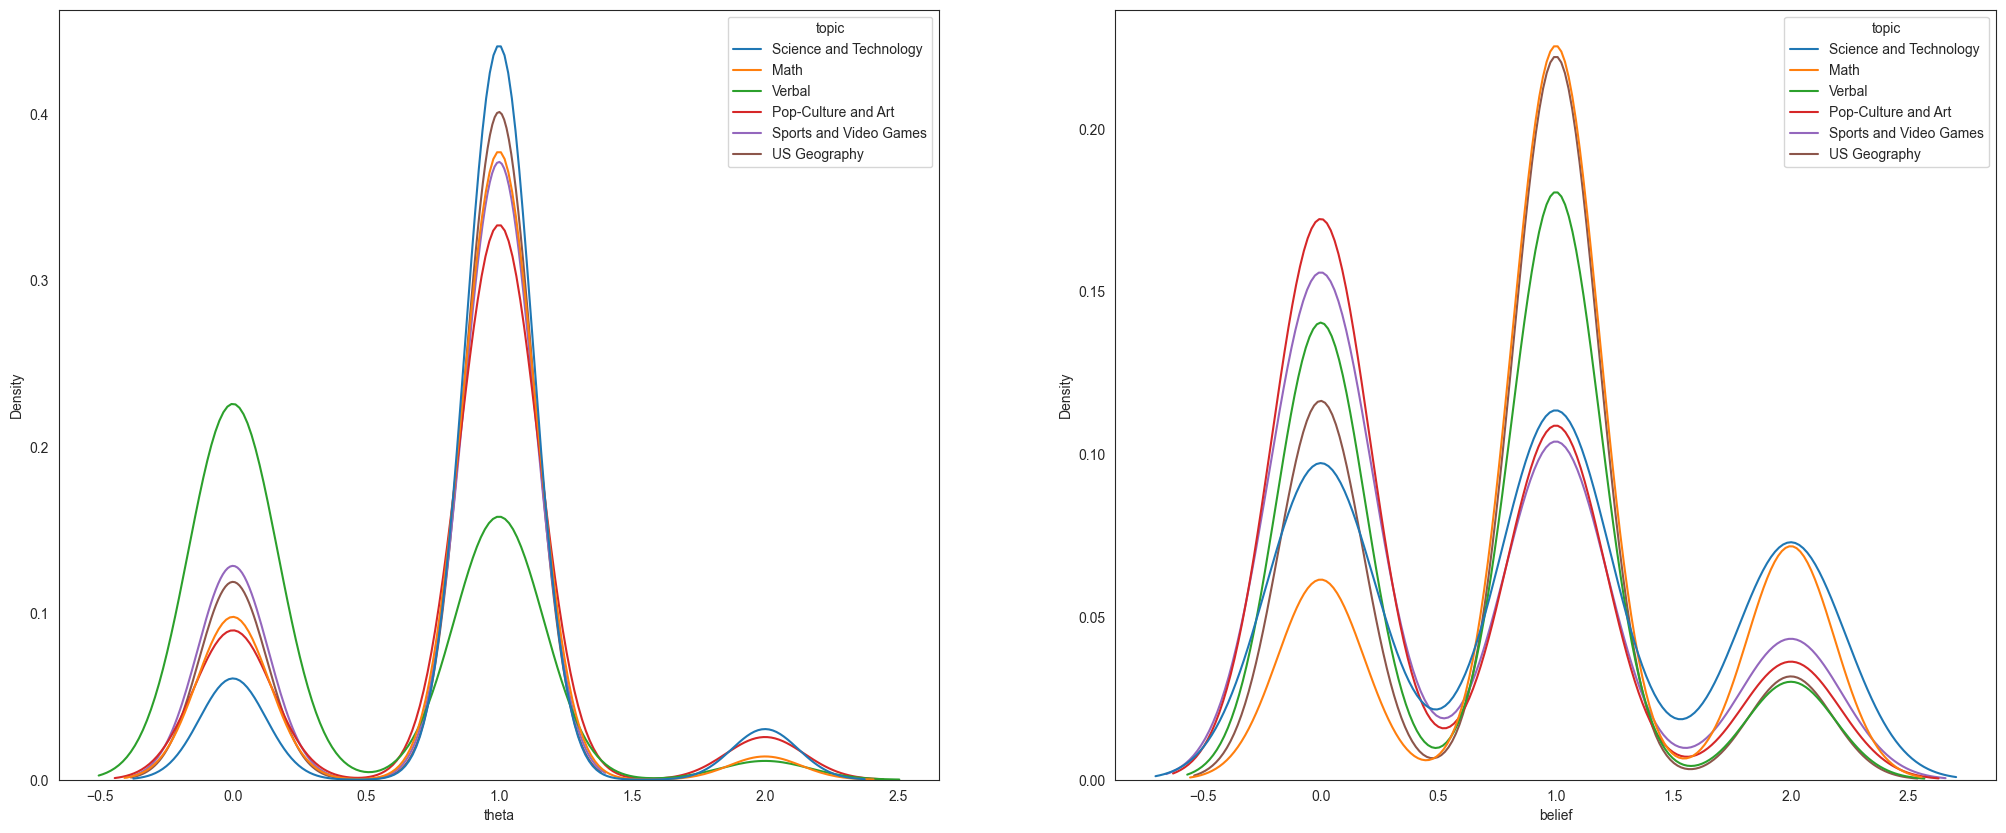

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
sns.kdeplot(data=updates, x='theta', hue='topic', ax=axs[0])
sns.kdeplot(data=updates, x='belief', hue='topic', ax=axs[1])


<Axes: xlabel='misspecification', ylabel='Probability'>

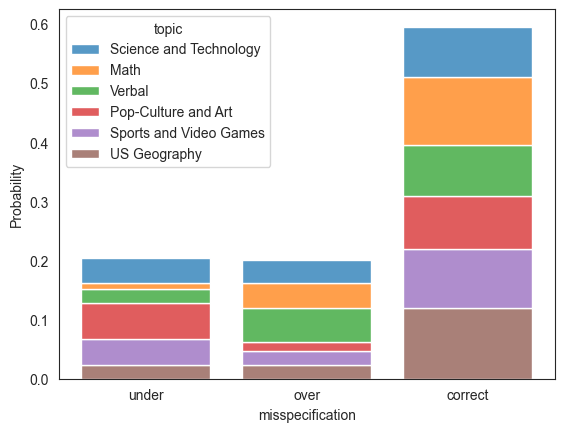

In [103]:
sns.histplot(data=updates, x='misspecification', hue='topic', multiple='stack', stat='probability', shrink=.8, discrete=True)

NameError: name 'ego_wide' is not defined